In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T 
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, Resize, ToTensor
from monai.losses import DiceLoss
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

c:\Users\avika\anaconda3\envs\Monai\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset("UCSC-VLAA/MedTrinity-25M", "25M_demo")

In [3]:
ds.shape

{'train': (161630, 3)}

In [4]:
torch.cuda.device_count()

1

In [5]:
torch.cuda.get_device_name()

'NVIDIA GeForce RTX 3060 Laptop GPU'

## Code

In [6]:
# Load dataset (limiting to a subset for faster processing)
subset_size = 10000 
ds_subset = ds["train"].select(range(subset_size))

# Define split ratio
split_ratio = 0.8  # 80% train, 20% validation
split_index = int(len(ds_subset) * split_ratio)

# Split the dataset
train_subset = ds["train"].select(range(split_index))
val_subset = ds["train"].select(range(split_index, len(ds_subset)))

# Create new dataset dictionary
split_ds = {"train": train_subset, "validation": val_subset}

# Print sizes
print(f"Train Size: {len(split_ds['train'])}")
print(f"Validation Size: {len(split_ds['validation'])}")

Train Size: 8000
Validation Size: 2000


In [7]:
len(ds_subset)

10000

Dataset Features: {'image': Image(mode=None, decode=True, id=None), 'id': Value(dtype='string', id=None), 'caption': Value(dtype='string', id=None)}


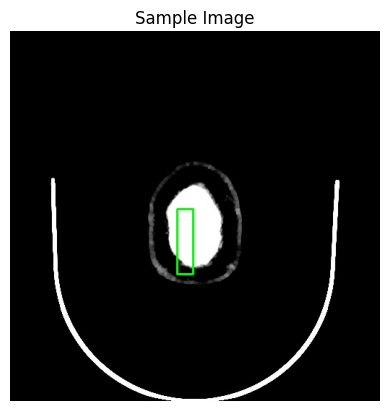

In [8]:
# Function to visualize an image (supports PIL images)
def visualize_image(image):
    if isinstance(image, Image.Image):  # Check if it's a PIL image
        image_array = np.array(image)
    else:
        raise TypeError("Unsupported image format")

    plt.imshow(image_array, cmap="gray")
    plt.title("Sample Image")
    plt.axis("off")
    plt.show()

# Checking dataset keys
print("Dataset Features:", train_subset.features)

# Visualize the first sample
sample_image = train_subset[4800]["image"]  # Image is likely a PIL object
visualize_image(sample_image)


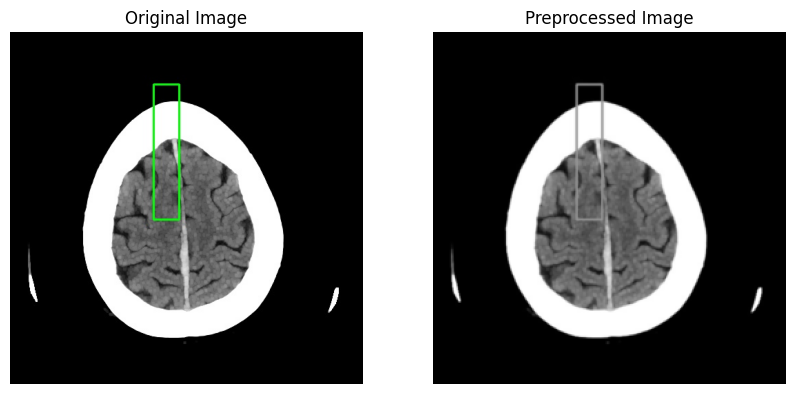

In [9]:
# Define preprocessing transforms
transform = T.Compose([
    T.Resize((256, 256)),  # Resize to 256x256
    T.Grayscale(num_output_channels=1),  # Convert to grayscale
    T.ToTensor(),  # Convert to tensor (0-1 range)
    T.Normalize(mean=[0.5], std=[0.5])  # Normalize (range -1 to 1)
])

# Function to preprocess images
def preprocess_image(image):
    if isinstance(image, Image.Image):  # Check if it's a PIL image
        return transform(image)  # Apply transformations
    else:
        raise TypeError("Unsupported image format")

# Function to visualize original and preprocessed images
def visualize_images(original, preprocessed):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(original, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Preprocessed image (convert tensor to NumPy)
    preprocessed_img = preprocessed.numpy().squeeze()  # Remove channel dimension
    axes[1].imshow(preprocessed_img, cmap="gray")
    axes[1].set_title("Preprocessed Image")
    axes[1].axis("off")

    plt.show()

# Process and visualize the first image
sample_image = train_subset[0]["image"]  # PIL Image
preprocessed_image = preprocess_image(sample_image)

# Show results
visualize_images(sample_image, preprocessed_image)


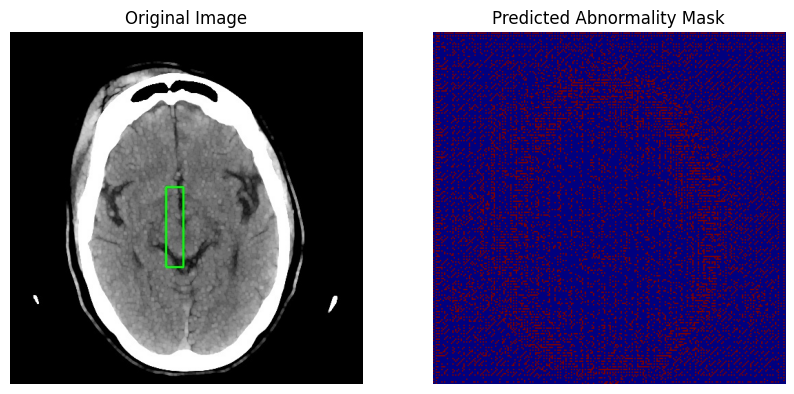

In [11]:
# Load MONAI's pre-trained UNet model for segmentation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,  # 2D since images are JPEGs
    in_channels=1,
    out_channels=2,  # Binary segmentation (normal vs. abnormal)
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
).to(device)

model.eval()  # Set to evaluation mode

# Function to preprocess and segment image
def predict_abnormality(image):
    if isinstance(image, Image.Image):  # Ensure it's a PIL image
        img_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    else:
        raise TypeError("Unsupported image format")
    
    with torch.no_grad():
        output = model(img_tensor)

    pred = torch.argmax(output, dim=1).cpu().numpy()[0]  # Get segmentation mask
    return pred

# Function to visualize original and segmented image
def visualize_segmentation(image):
    segmentation_mask = predict_abnormality(image)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show original image
    axes[0].imshow(image, cmap="gray")
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Show segmentation mask
    axes[1].imshow(segmentation_mask, cmap="jet")
    axes[1].set_title("Predicted Abnormality Mask")
    axes[1].axis("off")

    plt.show()

# Process and visualize the first image
sample_image = train_subset[38]["image"]  # PIL Image
visualize_segmentation(sample_image)

## Trying anomaly detection

In [12]:
from torchvision import transforms

# Define transformations
transform = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((256, 256)),
    ToTensor()
])

# Define a transformation pipeline for PIL images
image_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.Resize((256, 256)),  # Resize
    transforms.ToTensor()  # Convert to tensor (automatically scales to [0,1])
])

In [13]:
def preprocess_data(sample):
    img = sample["image"]  # This is a PIL image
    img = image_transform(img)  # Apply transformations
    return img

train_tensors = [preprocess_data(sample) for sample in train_subset]
val_tensors = [preprocess_data(sample) for sample in val_subset]
train_dataset = TensorDataset(torch.stack(train_tensors),)
val_dataset = TensorDataset(torch.stack(val_tensors),)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [14]:
# Load MONAI's pre-trained UNet model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=2,
    channels=(32, 64, 128, 256, 512, 1024   ),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
).to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# dice_loss = DiceLoss(to_onehot_y=True, softmax=True)
# ce_loss = torch.nn.CrossEntropyLoss()

In [15]:
def anomaly_loss(reconstructed, original):
    return F.mse_loss(reconstructed, original)  # Reconstruction loss

In [16]:
def calculate_accuracy(outputs, images):
    threshold = 0.5
    predictions = (outputs > threshold).float()
    correct = (predictions == images).float().mean()
    return correct.item()

In [17]:
# Store loss and accuracy
losses = []
accuracies = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    for images, in train_loader:
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = anomaly_loss(outputs, images)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += calculate_accuracy(outputs, images)

    avg_loss = epoch_loss / len(train_loader)
    avg_acc = epoch_acc / len(train_loader)
    losses.append(avg_loss)
    accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.4f}")

    

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_unet.pth")


Epoch 1/10, Loss: 0.0282, Accuracy: 0.7050
Epoch 2/10, Loss: 0.0021, Accuracy: 0.7088
Epoch 3/10, Loss: 0.0011, Accuracy: 0.7088
Epoch 4/10, Loss: 0.0007, Accuracy: 0.7088
Epoch 5/10, Loss: 0.0004, Accuracy: 0.7088
Epoch 6/10, Loss: 0.0003, Accuracy: 0.7088
Epoch 7/10, Loss: 0.0002, Accuracy: 0.7088
Epoch 8/10, Loss: 0.0002, Accuracy: 0.7088
Epoch 9/10, Loss: 0.0001, Accuracy: 0.7088
Epoch 10/10, Loss: 0.0001, Accuracy: 0.7088


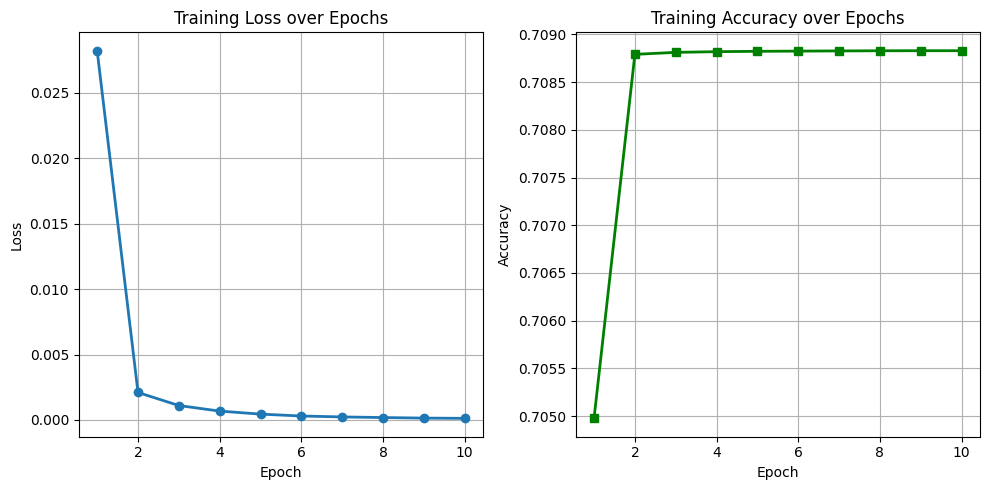

In [18]:
# Visualization
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(10, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, losses, marker='o', linewidth=2)
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracies, marker='s', color='green', linewidth=2)
plt.title("Training Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)

plt.tight_layout()
plt.show()